# Modifying FastPitch to Train on a Chinese and English Bilingual Dataset

This notebook is designed to provide a guide on how to train FastPitch on a Chinese and English bilingual dataset from scratch as part of the TTS pipeline. It contains the following sections:
  1. **Introduction**: FastPitch and HiFi-GAN in NeMo
  2. **Dataset Preparation**: How to prepare Chinese dataset for FastPitch
  3. **Training**: Example of FastPitch training and evaluation
  4. **(TODO) Finetuning from LJSpeech Acoustic Model**: Improving English speech quality by finetuning LJ Speech pretrained model

# License

> Copyright 2022 NVIDIA. All Rights Reserved.
> 
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
> 
>     http://www.apache.org/licenses/LICENSE-2.0
> 
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [1]:
"""
You can either run this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies# .
"""
BRANCH = 'main'
# # If you're using Colab and not running locally, uncomment and run this cell.
# !apt-get install sox libsndfile1 ffmpeg
# !pip install wget text-unidecode pynini==2.1.4 scipy==1.7.3
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]
# !wget https://raw.githubusercontent.com/NVIDIA/NeMo/main/nemo_text_processing/install_pynini.sh
# !bash install_pynini.sh
# !pip install pypinyin opencc-python-reimplemented

In [22]:
import json
import nemo
import torch
import librosa
import numpy as np

from pathlib import Path
from tqdm.notebook import tqdm

In [2]:
# let's download the files we need to run this tutorial

!mkdir -p NeMoChineseTTS
!cd NeMoChineseTTS && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/scripts/tts_dataset_files/zh/pinyin_dict_nv_22.10.txt
!cd NeMoChineseTTS && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/scripts/dataset_processing/tts/sfbilingual/get_data.py
!cd NeMoChineseTTS && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/fastpitch.py
!cd NeMoChineseTTS && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/hifigan_finetune.py
!cd NeMoChineseTTS && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/scripts/dataset_processing/tts/extract_sup_data.py
!cd NeMoChineseTTS && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/scripts/dataset_processing/tts/sfbilingual/ds_conf/ds_for_fastpitch_align.yaml
!cd NeMoChineseTTS && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/conf/zh/fastpitch_align_22050.yaml
!cd NeMoChineseTTS && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/conf/hifigan/hifigan.yaml
!cd NeMoChineseTTS && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/nemo_text_processing/text_normalization/zh/data/whitelist/default.tsv
!cd NeMoChineseTTS && mkdir -p model/train_ds && cd model/train_ds && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/conf/hifigan/model/train_ds/train_ds_finetune.yaml
!cd NeMoChineseTTS && mkdir -p model/validation_ds && cd model/validation_ds && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/conf/hifigan/model/validation_ds/val_ds_finetune.yaml
!cd NeMoChineseTTS && mkdir -p model/generator && cd model/generator && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/conf/hifigan/model/generator/v1.yaml

In [2]:
# FOR CODE REVIEW, WOULD REMOVE IT 
# BRANCH = 'zh_tts_new'
# !mkdir -p NeMoChineseTTS
# !cd NeMoChineseTTS && wget https://raw.githubusercontent.com/yuekaizhang/NeMo/$BRANCH/scripts/tts_dataset_files/zh/pinyin_dict_nv_22.10.txt
# !cd NeMoChineseTTS && wget https://raw.githubusercontent.com/yuekaizhang/NeMo/$BRANCH/scripts/dataset_processing/tts/sfbilingual/get_data.py
# !cd NeMoChineseTTS && wget https://raw.githubusercontent.com/yuekaizhang/NeMo/$BRANCH/examples/tts/fastpitch.py
# !cd NeMoChineseTTS && wget https://raw.githubusercontent.com/yuekaizhang/NeMo/$BRANCH/examples/tts/hifigan_finetune.py
# !cd NeMoChineseTTS && wget https://raw.githubusercontent.com/yuekaizhang/NeMo/$BRANCH/scripts/dataset_processing/tts/extract_sup_data.py
# !cd NeMoChineseTTS && wget https://raw.githubusercontent.com/yuekaizhang/NeMo/$BRANCH/scripts/dataset_processing/tts/sfbilingual/ds_conf/ds_for_fastpitch_align.yaml
# !cd NeMoChineseTTS && wget https://raw.githubusercontent.com/yuekaizhang/NeMo/$BRANCH/examples/tts/conf/zh/fastpitch_align_22050.yaml
# !cd NeMoChineseTTS && wget https://raw.githubusercontent.com/yuekaizhang/NeMo/$BRANCH/examples/tts/conf/hifigan/hifigan.yaml
# !cd NeMoChineseTTS && wget https://raw.githubusercontent.com/yuekaizhang/NeMo/$BRANCH/nemo_text_processing/text_normalization/zh/data/whitelist/default.tsv
# !cd NeMoChineseTTS && mkdir -p model/train_ds && cd model/train_ds && wget https://raw.githubusercontent.com/yuekaizhang/NeMo/$BRANCH/examples/tts/conf/hifigan/model/train_ds/train_ds_finetune.yaml
# !cd NeMoChineseTTS && mkdir -p model/validation_ds && cd model/validation_ds && wget https://raw.githubusercontent.com/yuekaizhang/NeMo/$BRANCH/examples/tts/conf/hifigan/model/validation_ds/val_ds_finetune.yaml
# !cd NeMoChineseTTS && mkdir -p model/generator && cd model/generator && wget https://raw.githubusercontent.com/yuekaizhang/NeMo/$BRANCH/examples/tts/conf/hifigan/model/generator/v1.yaml

--2022-10-27 06:18:53--  https://raw.githubusercontent.com/yuekaizhang/NeMo/zh_tts_new/scripts/tts_dataset_files/zh/pinyin_dict_nv_22.10.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3990 (3.9K) [text/plain]
Saving to: ‘pinyin_dict_nv_22.10.txt’

pinyin_dict_nv_22.1 100%[===================>]   3.90K  --.-KB/s    in 0s      

2022-10-27 06:18:54 (31.4 MB/s) - ‘pinyin_dict_nv_22.10.txt’ saved [3990/3990]

--2022-10-27 06:18:55--  https://raw.githubusercontent.com/yuekaizhang/NeMo/zh_tts_new/scripts/dataset_processing/tts/sfbilingual/get_data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443..

# Introduction

### FastPitch

FastPitch is non-autoregressive model for mel-spectrogram generation based on FastSpeech, conditioned on fundamental frequency contours. For more details about model, please refer to the original [paper](https://ieeexplore.ieee.org/abstract/document/9413889). Original [FastPitch model](https://ieeexplore.ieee.org/abstract/document/9413889) uses an external Tacotron 2 model trained on LJSpeech-1.1 to extract training alignments and estimate durations of input symbols. This implementation of FastPitch is based on [Deep Learning Examples](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechSynthesis/FastPitch), which uses an alignment mechanism proposed in [RAD-TTS](https://openreview.net/pdf?id=0NQwnnwAORi) and extended in [TTS Aligner](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9747707).

For more information on training a basic FastPitch model, please refer to [FastPitch_MixerTTS_Training.ipynb](https://github.com/NVIDIA/NeMo/blob/main/tutorials/tts/FastPitch_MixerTTS_Training.ipynb) tutorial.

### HiFiGAN
HiFiGAN is a generative adversarial network (GAN) model that generates audio from mel spectrograms. The generator uses transposed convolutions to upsample mel spectrograms to audio. For more details about the model, please refer to the original [paper](https://arxiv.org/abs/2010.05646). NeMo re-implementation of HiFi-GAN can be found [here](https://github.com/NVIDIA/NeMo/blob/main/nemo/collections/tts/models/hifigan.py).

# Dataset Preparation

We will show example of preprocessing and training using SF Bilingual Speech TTS dataset ([link](https://catalog.ngc.nvidia.com/orgs/nvidia/resources/sf_bilingual_speech_zh_en)). The dataset contains about 2,740 bilingual audio samples of a single female speaker and their corresponding text transcripts, each of them is an audio of around 5-6 seconds and have a total length of approximately 4.5 hours.

In this section, we will cover:
1. Downloading the dataset
2. Creating manifests
3. Normalizing text
4. Phonemization
5. Creating dataset config
6. Creating supplementary data

## 1. Downloading the dataset

In [5]:
!cd NeMoChineseTTS && mkdir DataChinese && \
    cd DataChinese && \
    ngc registry resource download-version "nvidia/sf_bilingual_speech_zh_en:v1" && \
    cd sf_bilingual_speech_zh_en_vv1 && \
    unzip SF_bilingual.zip

In [8]:
# DataChineseTTS directory looks like
!ls NeMoChineseTTS/DataChinese -R

NeMoChineseTTS/DataChinese:
sf_bilingual_speech_zh_en_vv1

NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1:
SF_bilingual  SF_bilingual.zip

NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual:
cache_dir  eval_filelist.txt  text_SF.txt  train_filelist.txt  wavs

NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/cache_dir:
zh_tn_True_deterministic_verbalizer.far

NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs:
com_SF_ce1.wav	   com_SF_ce1615.wav  com_SF_ce2231.wav  com_SF_ce381.wav
com_SF_ce10.wav    com_SF_ce1616.wav  com_SF_ce2232.wav  com_SF_ce382.wav
com_SF_ce100.wav   com_SF_ce1617.wav  com_SF_ce2233.wav  com_SF_ce383.wav
com_SF_ce1000.wav  com_SF_ce1618.wav  com_SF_ce2234.wav  com_SF_ce384.wav
com_SF_ce1001.wav  com_SF_ce1619.wav  com_SF_ce2235.wav  com_SF_ce385.wav
com_SF_ce1002.wav  com_SF_ce162.wav   com_SF_ce2236.wav  com_SF_ce386.wav
com_SF_ce1003.wav  com_SF_ce1620.wav  com_SF_ce2237.wav  com_SF_ce387.

## 2. Creating manifests 

We've created `scripts/dataset_processing/tts/sfbilingual/get_data.py` script that reads the `DataChineseTTS/SF_bilingual/text_SF.txt` provided with the dataset and generates the following fields per each datapoint:
1. `audio_filepath`: location of the wav file
2. `duration`: duration of the wav file
3. `text`: original text supplied by SF dataset
    
After that, the script would splits the datapoints into 3 buckets `train_manifest.json`, `val_manifest.json` and `test_manifest.json`, respectively.

In [ ]:
!(cd NeMoChineseTTS && \
    python3 get_data.py \
        --data-root ./DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/ \
        --manifests-path ./)

[NeMo W 2022-10-27 06:26:18 nemo_logging:349] /usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
      warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
    
[NeMo W 2022-10-27 06:26:21 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
Created DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/cache_dir/zh_tn_True_deterministic_verbalizer.far
0 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1.wav', 'duration': 4.72, 'text': 'NTHU對面有一條宵夜街。', 'normalized_text': 'NTHU对面有一条宵夜街。'}
1 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2.wav', 'duration': 5.864218, 'text': '免除GOOGLE在一樁誹謗官司中的法律責任。', 'normalized_text': '免除GOOGLE在一桩诽谤官司中的法律责任。'}
2 {'audio_filepath': '/

32 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce33.wav', 'duration': 6.342494, 'text': 'CULV筆電亦是筆電市場的趨勢之一。', 'normalized_text': 'CULV笔电亦是笔电市场的趋势之一。'}
33 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce34.wav', 'duration': 4.99873, 'text': 'IDC分析師LORENLOVERDE指出。', 'normalized_text': 'IDC分析师LORENLOVERDE指出。'}
34 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce35.wav', 'duration': 5.912517, 'text': '透過POP三功能整合其他信箱郵件。', 'normalized_text': '透过POP三功能整合其他信箱邮件。'}
35 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce36.wav', 'duration': 4.407483, 'text': 'FREEDMAN所指的外殼問題。', 'normalized_text': 'FREEDMAN所指的外壳问题。'}
36 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChi

66 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce67.wav', 'duration': 5.038095, 'text': 'UMC第四季的產能利用率來到低點。', 'normalized_text': 'UMC第四季的产能利用率来到低点。'}
67 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce68.wav', 'duration': 6.519864, 'text': '好讓自家作業系統明年隨他們製造的NETBOOK出貨。', 'normalized_text': '好让自家作业系统明年随他们制造的NETBOOK出货。'}
68 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce69.wav', 'duration': 5.571519, 'text': 'NCU位置偏僻，學生大多吃校內餐廳。', 'normalized_text': 'NCU位置偏僻,学生大多吃校内餐厅。'}
69 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce70.wav', 'duration': 4.504626, 'text': '英特爾發言人CLAUDINEMANGANO說。', 'normalized_text': '英特尔发言人CLAUDINEMANGANO说。'}
70 {'audio_filepath': '/mnt/sams

100 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce101.wav', 'duration': 5.04, 'text': '大多數小筆電執行的是WINDOWSXP。', 'normalized_text': '大多数小笔电执行的是WINDOWSXP。'}
101 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce102.wav', 'duration': 5.62, 'text': '企業仍必須搭配IPSECVPN的產品。', 'normalized_text': '企业仍必须搭配IPSECVPN的产品。'}
102 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce103.wav', 'duration': 5.48, 'text': 'ANDROID應用程式是以JAVA編寫。', 'normalized_text': 'ANDROID应用程式是以JAVA编写。'}
103 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce104.wav', 'duration': 4.46, 'text': '這跟微軟BING有何關連？', 'normalized_text': '这跟微软BING有何关连?'}
104 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTT

134 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce135.wav', 'duration': 3.99415, 'text': 'MIT與APACHE授權。', 'normalized_text': 'MIT与APACHE授权。'}
135 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce136.wav', 'duration': 4.901905, 'text': '信任運算聯盟的TNC工作小組。', 'normalized_text': '信任运算联盟的TNC工作小组。'}
136 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce137.wav', 'duration': 7.398231, 'text': '在選擇防曬乳液時，應選用適當的SPF係數的防曬產品。', 'normalized_text': '在选择防晒乳液时,应选用适当的SPF系数的防晒产品。'}
137 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce138.wav', 'duration': 4.76576, 'text': '為FIREFOX推出ANDROID版鋪路。', 'normalized_text': '为FIREFOX推出ANDROID版铺路。'}
138 {'audio_filepath': '/mnt/samsung-t7/yuek

168 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce169.wav', 'duration': 4.633424, 'text': 'GLOBAL是由AMD獨立分出。', 'normalized_text': 'GLOBAL是由AMD独立分出。'}
169 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce170.wav', 'duration': 8.166395, 'text': '這似乎暗示了目前一TB硬碟在市場上供過於求的狀況。', 'normalized_text': '这似乎暗示了目前一TB硬碟在市场上供过于求的状况。'}
170 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce171.wav', 'duration': 9.672245, 'text': 'SI與ISV等夥伴可向政府單位提供產品的安全防護能力較高。', 'normalized_text': 'SI与ISV等伙伴可向政府单位提供产品的安全防护能力较高。'}
171 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce172.wav', 'duration': 9.150975, 'text': '微軟的開放原始碼授權MS－PL則在開放原始碼領域小有進展。', 'normalized_text': '微软的开放原始码授权MS-PL则在开放原始码领域小有

202 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce203.wav', 'duration': 6.380272, 'text': '由於ANDROID與CHROMEOS都是開放原始碼。', 'normalized_text': '由于ANDROID与CHROMEOS都是开放原始码。'}
203 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce204.wav', 'duration': 4.269161, 'text': '超微執行長DIRKMEYER表示。', 'normalized_text': '超微执行长DIRKMEYER表示。'}
204 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce205.wav', 'duration': 5.019773, 'text': '該公司董事會主席DEANSINGLETON表示。', 'normalized_text': '该公司董事会主席DEANSINGLETON表示。'}
205 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce206.wav', 'duration': 4.879048, 'text': '指出美國仍是IPHONE最大市場。', 'normalized_text': '指出美国仍是IPHONE最大市场。'}
206 {'audio_filepath': '

236 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce237.wav', 'duration': 4.688798, 'text': 'PAQUET表示該版也快出來了。', 'normalized_text': 'PAQUET表示该版也快出来了。'}
237 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce238.wav', 'duration': 10.913605, 'text': '除了自即日起上市兩款型號分別為VNB一零零與VNB一零一的十寸迷你筆電外。', 'normalized_text': '除了自即日起上市两款型号分别为VNB一零零与VNB一零一的十寸迷你笔电外。'}
238 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce239.wav', 'duration': 7.859592, 'text': '且三分之二的WEB網站都相當脆弱而易成為被攻擊的目標。', 'normalized_text': '且三分之二的WEB网站都相当脆弱而易成为被攻击的目标。'}
239 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce240.wav', 'duration': 7.410476, 'text': '想要把這畫面抓下來變成JPG圖檔的話，該怎麼做呢？', 'normalized_text': '想要把这画面抓下来

270 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce271.wav', 'duration': 7.296553, 'text': '由該公司副行政主席梁乃鵬出任TVBS董事長。', 'normalized_text': '由该公司副行政主席梁乃鹏出任TVBS董事长。'}
271 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce272.wav', 'duration': 7.417506, 'text': '系統開發廠商SWISSTIMING樹立鐵三角的合作典範，', 'normalized_text': '系统开发厂商SWISSTIMING树立铁三角的合作典范,'}
272 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce273.wav', 'duration': 5.966259, 'text': 'MANAGER和ANALYZER管理與分析設備。', 'normalized_text': 'MANAGER和ANALYZER管理与分析设备。'}
273 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce274.wav', 'duration': 6.651565, 'text': '華碩和聯想將與GOOGLE合作推出CHROMEOS。', 'normalized_text': '华硕和联想将与GOOGLE合作推出CHRO

304 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce305.wav', 'duration': 7.686259, 'text': 'CHROME的擴充套件技術用的是與網頁相同的介面技術。', 'normalized_text': 'CHROME的扩充套件技术用的是与网页相同的介面技术。'}
305 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce306.wav', 'duration': 4.783764, 'text': 'GOOGLE旗下的影音分享網站YOUTUBE。', 'normalized_text': 'GOOGLE旗下的影音分享网站YOUTUBE。'}
306 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce307.wav', 'duration': 6.073741, 'text': '這家股份有限公司是製造PCB的大廠。', 'normalized_text': '这家股份有限公司是制造PCB的大厂。'}
307 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce308.wav', 'duration': 5.536236, 'text': 'PROBOOK的外型會偏向消費機種。', 'normalized_text': 'PROBOOK的外型会偏向消费机种。'}
308 {'audio_filepath

338 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce339.wav', 'duration': 4.085034, 'text': 'IBM勢必會受到傷害。', 'normalized_text': 'IBM势必会受到伤害。'}
339 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce340.wav', 'duration': 4.944989, 'text': '你們都和自己的BF天天在一起嗎？', 'normalized_text': '你们都和自己的BF天天在一起吗?'}
340 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce341.wav', 'duration': 7.955011, 'text': '一開始聽到CPBL要仿效美國的制度，著實讓我大吃一驚。', 'normalized_text': '一开始听到CPBL要仿效美国的制度,著实让我大吃一惊。'}
341 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce342.wav', 'duration': 4.944989, 'text': '正是我們開發IPODTOUCH的原因。', 'normalized_text': '正是我们开发IPODTOUCH的原因。'}
342 {'audio_filepath': '/mnt/samsung-t7/yuekai

372 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce373.wav', 'duration': 5.805034, 'text': 'SPRINT今年至少會推一支ANDROID手機。', 'normalized_text': 'SPRINT今年至少会推一支ANDROID手机。'}
373 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce374.wav', 'duration': 5.804989, 'text': '這也是中華電信首次銷售IPHONE空機。', 'normalized_text': '这也是中华电信首次销售IPHONE空机。'}
374 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce375.wav', 'duration': 5.106259, 'text': '微軟也與少數LINUX業者和解。', 'normalized_text': '微软也与少数LINUX业者和解。'}
375 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce376.wav', 'duration': 5.32127, 'text': '根據BBC一項最新民調顯示。', 'normalized_text': '根据BBC一项最新民调显示。'}
376 {'audio_filepath': '/mnt/samsung-t7/yueka

406 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce407.wav', 'duration': 7.112608, 'text': '前後兩屆的最佳球員展開了PK大賽，到底誰比較強？', 'normalized_text': '前后两届的最佳球员展开了PK大赛,到底谁比较强?'}
407 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce408.wav', 'duration': 5.556735, 'text': '這項發展將讓NAC的防護能力更強。', 'normalized_text': '这项发展将让NAC的防护能力更强。'}
408 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce409.wav', 'duration': 5.779002, 'text': 'GOOGLE也應向讀者說明哪些資料會被收集。', 'normalized_text': 'GOOGLE也应向读者说明哪些资料会被收集。'}
409 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce410.wav', 'duration': 5.690068, 'text': '我們要先找到要部署SEP的個人端電腦。', 'normalized_text': '我们要先找到要部署SEP的个人端电脑。'}
410 {'audio_filepath': '/mnt

440 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce441.wav', 'duration': 6.045714, 'text': '今天是老王的BD慶祝趴，十點錢櫃集合。', 'normalized_text': '今天是老王的BD庆祝趴,十点钱柜集合。'}
441 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce443.wav', 'duration': 6.712517, 'text': '該組織目前已經跟七家商店洽談HORIZON計畫。', 'normalized_text': '该组织目前已经跟七家商店洽谈HORIZON计划。'}
442 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce444.wav', 'duration': 3.645215, 'text': 'CHROME符合戴爾的目標。', 'normalized_text': 'CHROME符合戴尔的目标。'}
443 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce445.wav', 'duration': 4.845488, 'text': '同時繼續使用OUTLOOK作為前端。', 'normalized_text': '同时继续使用OUTLOOK作为前端。'}
444 {'audio_filepath': '/mnt/samsung-t7/yu

474 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce476.wav', 'duration': 4.489841, 'text': '線上版OFFICE一定所向無敵嗎？', 'normalized_text': '线上版OFFICE一定所向无敌吗?'}
475 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce477.wav', 'duration': 4.800998, 'text': '解除與PALMPRE同步化的功能。', 'normalized_text': '解除与PALMPRE同步化的功能。'}
476 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce478.wav', 'duration': 7.37932, 'text': 'HTTP是網際網路上應用最為廣泛的一種網路協議。', 'normalized_text': 'HTTP是网际网路上应用最为广泛的一种网路协议。'}
477 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce479.wav', 'duration': 5.51229, 'text': '但目前你已經可使用免費試用BETA版。', 'normalized_text': '但目前你已经可使用免费试用BETA版。'}
478 {'audio_filepath': '/mnt/samsung-t7/

508 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce510.wav', 'duration': 5.1122, 'text': 'GEARS是一種FIREFOX外掛程式。', 'normalized_text': 'GEARS是一种FIREFOX外挂程式。'}
509 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce511.wav', 'duration': 6.223537, 'text': '現在這些產品都加入GOOGLE的正式產品線中。', 'normalized_text': '现在这些产品都加入GOOGLE的正式产品线中。'}
510 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce512.wav', 'duration': 8.357324, 'text': 'KINGSTON現場設有舞臺區提供勁歌熱舞以及精采刺激的表演。', 'normalized_text': 'KINGSTON现场设有舞台区提供劲歌热舞以及精采刺激的表演。'}
511 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce513.wav', 'duration': 5.423356, 'text': '日前接受ITHOME電腦報周刊的專訪時。', 'normalized_text': '日前接受ITHOME电脑报周刊的专访时。'}
512 {'

542 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce544.wav', 'duration': 4.978821, 'text': '指出IPHONE主宰了行動網路的使用。', 'normalized_text': '指出IPHONE主宰了行动网路的使用。'}
543 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce545.wav', 'duration': 8.179501, 'text': '此項產品NIS，要等待約莫兩個禮拜才會再補新的貨進來。', 'normalized_text': '此项产品NIS,要等待约莫两个礼拜才会再补新的货进来。'}
544 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce546.wav', 'duration': 4.5639, 'text': '日後市場上只會有八G的IPHONE。', 'normalized_text': '日后市场上只会有八G的IPHONE。'}
545 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce547.wav', 'duration': 5.038095, 'text': '並可直接在JUNIPER路由平臺上執行。', 'normalized_text': '并可直接在JUNIPER路由平台上执行。'}
546 {'audio_filepath': '/m

576 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce578.wav', 'duration': 6.045714, 'text': 'WHO是目前世界上重要的衛生組織。', 'normalized_text': 'WHO是目前世界上重要的卫生组织。'}
577 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce579.wav', 'duration': 7.40898, 'text': '並已提交給LINUX核心社群，成為LINUX樹狀架構的一環。', 'normalized_text': '并已提交给LINUX核心社群,成为LINUX树状架构的一环。'}
578 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce580.wav', 'duration': 9.602041, 'text': '新服務將把該公司的SAS服務自中小企業延伸到大型企業客戶。', 'normalized_text': '新服务将把该公司的SAS服务自中小企业延伸到大型企业客户。'}
579 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce581.wav', 'duration': 6.104989, 'text': '可擴充到十六GB記憶體的SUPERMICRO主機板。', 'normalized_text': '可扩充到十六GB记忆体的SUPERM

610 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce612.wav', 'duration': 3.674875, 'text': '資訊界三巨頭MICROSOFT。', 'normalized_text': '资讯界三巨头MICROSOFT。'}
611 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce613.wav', 'duration': 7.40898, 'text': '施華洛世奇水晶可以通過歐盟ROHS的限制。', 'normalized_text': '施华洛世奇水晶可以通过欧盟ROHS的限制。'}
612 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce614.wav', 'duration': 4.504626, 'text': 'QUALCOMM等晶片製造商供應。', 'normalized_text': 'QUALCOMM等晶片制造商供应。'}
613 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce615.wav', 'duration': 6.104989, 'text': '不會立即取代市占率逐漸流失的INTERNETEXPLORER。', 'normalized_text': '不会立即取代市占率逐渐流失的INTERNETEXPLORER。'}
614 {'audio_filepath': 

644 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce646.wav', 'duration': 4.741723, 'text': '顯示BING的斬獲相當有限。', 'normalized_text': '显示BING的斩获相当有限。'}
645 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce647.wav', 'duration': 5.630794, 'text': 'NCC瞭解到民眾對上網成本的看法。', 'normalized_text': 'NCC了解到民众对上网成本的看法。'}
646 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce648.wav', 'duration': 4.030476, 'text': '星光大道潘裕文出EP了！', 'normalized_text': '星光大道潘裕文出EP了!'}
647 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce649.wav', 'duration': 6.164263, 'text': '小筆電預計會加入OLED超優質面板。', 'normalized_text': '小笔电预计会加入OLED超优质面板。'}
648 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/Data

679 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce681.wav', 'duration': 6.579184, 'text': '由於臺灣IBM會協助通用數碼舉辦系列研討會。', 'normalized_text': '由于台湾IBM会协助通用数码举办系列研讨会。'}
680 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce682.wav', 'duration': 6.756961, 'text': '而這正是MOZILLAFIREFOX瀏覽器為人稱道的功能。', 'normalized_text': '而这正是MOZILLAFIREFOX浏览器为人称道的功能。'}
681 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce683.wav', 'duration': 7.231156, 'text': '讓使用者能更輕易地更換SASEXPANDBOARD模組。', 'normalized_text': '让使用者能更轻易地更换SASEXPANDBOARD模组。'}
682 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce684.wav', 'duration': 6.46059, 'text': '負責微軟開發者與平臺推廣計畫的ABU－HONDA表示。', 'normalized_text': '负责微软开发者与平台推

712 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce714.wav', 'duration': 5.850113, 'text': '想去MIT讀研究生，需要什麼條件？', 'normalized_text': '想去MIT读研究生,需要什么条件?'}
713 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce715.wav', 'duration': 9.225578, 'text': 'OS的說話者，不一定是故事中的角色，他可能從頭到尾都沒有現身。', 'normalized_text': 'OS的说话者,不一定是故事中的角色,他可能从头到尾都没有现身。'}
714 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce716.wav', 'duration': 5.115601, 'text': '進而快速提升PRESALE的能力。', 'normalized_text': '进而快速提升PRESALE的能力。'}
715 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce717.wav', 'duration': 5.596553, 'text': '就是向客戶介紹SMARTBOOK到底是什麼。', 'normalized_text': '就是向客户介绍SMARTBOOK到底是什么。'}
716 {'audio_filepa

747 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce749.wav', 'duration': 8.657143, 'text': 'NEXTWINDOW的技術不需在玻璃上塗上一層特製的塗料或薄膜。', 'normalized_text': 'NEXTWINDOW的技术不需在玻璃上涂上一层特制的涂料或薄膜。'}
748 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce750.wav', 'duration': 4.984399, 'text': '並提供啟動INPRIVATE隱私瀏覽。', 'normalized_text': '并提供启动INPRIVATE隐私浏览。'}
749 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce751.wav', 'duration': 8.045034, 'text': '較低的價值可能讓某些FACEBOOK員工不願賣股給DST。', 'normalized_text': '较低的价值可能让某些FACEBOOK员工不愿卖股给DST。'}
750 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce752.wav', 'duration': 5.334195, 'text': '六百MEGAHZ雙核心DEEP處理器。', 'normalized_text': '六百MEGAHZ双核心DEEP处

781 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce783.wav', 'duration': 5.377959, 'text': '這家公司最新推出的GMT概念手錶。', 'normalized_text': '这家公司最新推出的GMT概念手表。'}
782 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce784.wav', 'duration': 7.64059, 'text': '軟體即服務SAS型態的IT委外項目雖然最少。', 'normalized_text': '软体即服务SAS型态的IT委外项目虽然最少。'}
783 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce785.wav', 'duration': 9.73932, 'text': '這也是臺灣產官界會計劃與中國資服業者一同搶攻IT服務市場的原因。', 'normalized_text': '这也是台湾产官界会计划与中国资服业者一同抢攻IT服务市场的原因。'}
784 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce786.wav', 'duration': 4.95161, 'text': '我曾在TSMC工作了兩三年。', 'normalized_text': '我曾在TSMC工作了两三年。'}
785 {'audio_filepath': '/

815 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce817.wav', 'duration': 4.984444, 'text': '展示針對不同產業的新一代IT應用。', 'normalized_text': '展示针对不同产业的新一代IT应用。'}
816 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce818.wav', 'duration': 6.427256, 'text': '它主要蒐集根據CASPIAN系統開發的應用程式。', 'normalized_text': '它主要搜集根据CASPIAN系统开发的应用程式。'}
817 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce819.wav', 'duration': 4.754875, 'text': '不過今天看到一位WEBDEVELOPER。', 'normalized_text': '不过今天看到一位WEBDEVELOPER。'}
818 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce820.wav', 'duration': 7.378231, 'text': '例如DELL十九寸寬螢幕平面顯示器售價五百元。', 'normalized_text': '例如DELL十九寸宽萤幕平面显示器售价五百元。'}
819 {'audio_filepath':

849 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce851.wav', 'duration': 6.263356, 'text': 'LINUX與開放原始碼社群一再遭遇的問題。', 'normalized_text': 'LINUX与开放原始码社群一再遭遇的问题。'}
850 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce852.wav', 'duration': 11.018186, 'text': '與LCD技術一樣，DMD芯片尺寸是決定投影機體積和重量的重要因素。', 'normalized_text': '与LC D技术一样,DMD芯片尺寸是决定投影机体积和重量的重要因素。'}
851 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce853.wav', 'duration': 3.8039, 'text': 'LINUX基礎先修課程。', 'normalized_text': 'LINUX基础先修课程。'}
852 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce854.wav', 'duration': 6.361678, 'text': '願意選擇我們繼續作為IP網路設備的代理商。', 'normalized_text': '愿意选择我们继续作为IP网路设备的代理商。'}
853 {'audio_filepa

883 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce885.wav', 'duration': 5.607483, 'text': '則將在本季推出二TB容量的版本。', 'normalized_text': '则将在本季推出二TB容量的版本。'}
884 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce886.wav', 'duration': 8.066893, 'text': '禁止該ACTIVEX控制項在INTERNETEXPLORER中運行。', 'normalized_text': '禁止该ACTIVEX控制项在INTERNETEXPLORER中运行。'}
885 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce887.wav', 'duration': 3.639955, 'text': 'HP教育訓練中心。', 'normalized_text': 'HP教育训练中心。'}
886 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce888.wav', 'duration': 5.181179, 'text': '若欲此項服務請點MO選項。', 'normalized_text': '若欲此项服务请点MO选项。'}
887 {'audio_filepath': '/mnt/samsung-t7/yuekai/t

917 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce919.wav', 'duration': 5.14839, 'text': '並將信賴可靠的形象深植在TALL上。', 'normalized_text': '并将信赖可靠的形象深植在TALL上。'}
918 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce920.wav', 'duration': 7.738957, 'text': '飯島愛從AV圈轉戰日本綜藝圈，表現十分亮眼。', 'normalized_text': '饭岛爱从AV圈转战日本综艺圈,表现十分亮眼。'}
919 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce921.wav', 'duration': 6.722404, 'text': '在社交網站的流量排名僅次於無名小站與PICKNET。', 'normalized_text': '在社交网站的流量排名仅次于无名小站与PICKNET。'}
920 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce922.wav', 'duration': 6.525669, 'text': 'TI全球行動運算商業發展負責人RAMESHIYER說。', 'normalized_text': 'TI全球行动运算商业发展负责人RAMESHIYER说。'}
921 {'a

951 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce953.wav', 'duration': 5.082812, 'text': '有助於GOBLIN未來進入小筆電市場。', 'normalized_text': '有助于GOBLIN未来进入小笔电市场。'}
952 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce954.wav', 'duration': 6.951973, 'text': '透過隨身碟安裝WINDOWSSEVEN是考慮中的選項之一。', 'normalized_text': '透过随身碟安装WINDOWSSEVEN是考虑中的选项之一。'}
953 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce955.wav', 'duration': 7.80458, 'text': '所有大型電信營運商都認定了LTE會是未來的主流。', 'normalized_text': '所有大型电信营运商都认定了LTE会是未来的主流。'}
954 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce956.wav', 'duration': 6.984762, 'text': 'PC軟體製造商會不會像手機軟體擁抱IPHONE那般。', 'normalized_text': 'PC软体制造商会不会像手机软体拥抱IPHONE那般。

985 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce987.wav', 'duration': 6.689615, 'text': '這也是微軟首次直接發表給LINUX社群的程式碼。', 'normalized_text': '这也是微软首次直接发表给LINUX社群的程式码。'}
986 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce988.wav', 'duration': 5.14839, 'text': '完善管理集團內複雜多樣的IT設備。', 'normalized_text': '完善管理集团内复杂多样的IT设备。'}
987 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce989.wav', 'duration': 5.968209, 'text': '八十GB固態硬碟會降個一百美元左右。', 'normalized_text': '八十GB固态硬碟会降个一百美元左右。'}
988 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce990.wav', 'duration': 3.869478, 'text': '魚油含有豐富的DHA。', 'normalized_text': '鱼油含有丰富的DHA。'}
989 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/Ne

1019 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1021.wav', 'duration': 6.46, 'text': 'FIREFOX外掛程式網站找到所有應用程式。', 'normalized_text': 'FIREFOX外挂程式网站找到所有应用程式。'}
1020 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1022.wav', 'duration': 7.709977, 'text': '幫助客戶降低成本並大幅提昇整體IT架構的效率。', 'normalized_text': '帮助客户降低成本并大幅提升整体IT架构的效率。'}
1021 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1023.wav', 'duration': 8.489977, 'text': '第一步是降低現有八十GB和一百六十GB固態硬碟的成本。', 'normalized_text': '第一步是降低现有八十GB和一百六十GB固态硬碟的成本。'}
1022 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1024.wav', 'duration': 8.4, 'text': '之前WINDOWSVISTA從測試版換到正式產品也是這樣。', 'normalized_text': '之前WINDOWSVISTA从测试版换到正式产

1053 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1055.wav', 'duration': 8.14, 'text': '愈來愈多的手機中都內建了MMS的功能。', 'normalized_text': '愈来愈多的手机中都内建了MMS的功能。'}
1054 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1056.wav', 'duration': 5.44, 'text': '推出一款觸控螢幕式的ANDROID手機。', 'normalized_text': '推出一款触控萤幕式的ANDROID手机。'}
1055 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1057.wav', 'duration': 5.729977, 'text': 'CNX以單日同一網計價優惠為限。', 'normalized_text': 'CNX以单日同一网计价优惠为限。'}
1056 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1058.wav', 'duration': 6.510023, 'text': '而該TABLE中若有欄位宣告成STRING等型態。', 'normalized_text': '而该TABLE中若有栏位宣告成STRING等型态。'}
1057 {'audio_filepath': '/mnt/sa

1088 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1090.wav', 'duration': 6.875147, 'text': '筆電AC電源無法開機，請查詢相關網站。', 'normalized_text': '笔电AC电源无法开机,请查询相关网站。'}
1089 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1091.wav', 'duration': 5.500317, 'text': '有助於提昇GOBLIN未來於小筆電。', 'normalized_text': '有助于提升GOBLIN未来于小笔电。'}
1090 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1092.wav', 'duration': 4.34, 'text': '專案PRESALE技巧研習班。', 'normalized_text': '专案PRESALE技巧研习班。'}
1091 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1093.wav', 'duration': 8.849977, 'text': '企業雖可透過LEADPROOF監控與限制哪些員工。', 'normalized_text': '企业虽可透过LEADPROOF监控与限制哪些员工。'}
1092 {'audio_filepath': '/mnt/sams

1122 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1124.wav', 'duration': 5.449977, 'text': '該公司也逐漸在WEBEX加入文件。', 'normalized_text': '该公司也逐渐在WEBEX加入文件。'}
1123 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1125.wav', 'duration': 10.929977, 'text': '多媒體電腦輔助教學是在擁有MPC標準設備之後，發展出的電腦輔助教學方式。', 'normalized_text': '多媒体电脑辅助教学是在拥有MPC标准设备之后,发展出的电脑辅助教学方式。'}
1124 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1126.wav', 'duration': 3.110023, 'text': '中華英雄ONLINE。', 'normalized_text': '中华英雄ONLINE。'}
1125 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1127.wav', 'duration': 7.9, 'text': 'GOOGLE並未馬上對FACEBOOK會員大量湧現跡象做出回應。', 'normalized_text': 'GOOGLE并未马上对FACEBOOK会员大量涌现迹象做出回应

1155 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1157.wav', 'duration': 4.329977, 'text': 'OFFICE網路應用程式。', 'normalized_text': 'OFFICE网路应用程式。'}
1156 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1158.wav', 'duration': 4.46, 'text': 'MOZILLA抱持正面的看法。', 'normalized_text': 'MOZILLA抱持正面的看法。'}
1157 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1159.wav', 'duration': 4.689977, 'text': '開發者正在研究這個NDK。', 'normalized_text': '开发者正在研究这个NDK。'}
1158 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1160.wav', 'duration': 4.24, 'text': '這部分是由CURTISWONG主導。', 'normalized_text': '这部分是由CURTISWONG主导。'}
1159 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChi

1190 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1192.wav', 'duration': 6.94, 'text': '我們將利用CORE的MELODY實作軟體式的ISCSI環境。', 'normalized_text': '我们将利用CORE的MELODY实作软体式的ISCSI环境。'}
1191 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1193.wav', 'duration': 6.730023, 'text': '在六月就發表TIMELINE系列的宏碁。', 'normalized_text': '在六月就发表TIMELINE系列的宏碁。'}
1192 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1194.wav', 'duration': 7.52, 'text': '成為全球使用率最高PC軟硬體組合平臺的硬體部分。', 'normalized_text': '成为全球使用率最高PC软硬体组合平台的硬体部分。'}
1193 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1195.wav', 'duration': 7.529977, 'text': '很多西方國家早已不用WC表示廁所了。', 'normalized_text': '很多西方国家早已不用WC表示厕所了。'}
1194 {'a

1224 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1226.wav', 'duration': 5.529977, 'text': '搭配VMWARE新版的VSPHERE套件。', 'normalized_text': '搭配VMWARE新版的VSPHERE套件。'}
1225 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1227.wav', 'duration': 8.161361, 'text': '奇科電腦在全球LINUX教育訓練市場已受到相當肯定。', 'normalized_text': '奇科电脑在全球LINUX教育训练市场已受到相当肯定。'}
1226 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1228.wav', 'duration': 6.2, 'text': '這是只適用於FIREFOX的瀏覽器外掛程式。', 'normalized_text': '这是只适用于FIREFOX的浏览器外挂程式。'}
1227 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1229.wav', 'duration': 5.709977, 'text': '請問積體電路與IC設計有何不同？', 'normalized_text': '请问积体电路与IC设计有何不同?'}
1228 {'audio_filepa

1258 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1260.wav', 'duration': 5.78, 'text': '它同時也是第一批LIMOFOUNDATION的手機之一。', 'normalized_text': '它同时也是第一批LIMOFOUNDATION的手机之一。'}
1259 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1261.wav', 'duration': 8.209977, 'text': '目前CREATIVE正試圖提昇ANDROID系統在EGG上的效能。', 'normalized_text': '目前CREATIVE正试图提升ANDROID系统在EGG上的效能。'}
1260 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1262.wav', 'duration': 5.9, 'text': 'MATTHEW花了半個小時才買到這支IPHONE。', 'normalized_text': 'MATTHEW花了半个小时才买到这支IPHONE。'}
1261 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1263.wav', 'duration': 4.52, 'text': 'CLOUD並不需要額外的硬體。', 'normalized_text': 'CLOUD并不需要额外的硬

1291 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1293.wav', 'duration': 5.478413, 'text': '我們已經看了電子郵件夾帶的POWERPOINT檔案。', 'normalized_text': '我们已经看了电子邮件夹带的POWERPOINT档案。'}
1292 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1294.wav', 'duration': 6.015601, 'text': '任職於IDSOFTWARE的JOHNCARMACK同意SCHADE的看法。', 'normalized_text': '任职于IDSOFTWARE的JOHNCARMACK同意SCHADE的看法。'}
1293 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1295.wav', 'duration': 5.981134, 'text': '紐約時報公司董事長ARTHURSULZBERGERJOURNAL。', 'normalized_text': '纽约时报公司董事长ARTHURSULZBERGERJOURNAL。'}
1294 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1296.wav', 'duration': 4.889977, 'text': '使用POWERPC晶片的舊版MACS

1324 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1326.wav', 'duration': 6.354331, 'text': '這次臨陣代替STEVEJOBS上場代打的是PHILSCHILLER。', 'normalized_text': '这次临阵代替STEVEJOBS上场代打的是PHILSCHILLER。'}
1325 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1327.wav', 'duration': 7.443628, 'text': '最新的兩款手機MAGIC跟HERO已經立下很高的標竿。', 'normalized_text': '最新的两款手机MAGIC跟HERO已经立下很高的标竿。'}
1326 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1328.wav', 'duration': 7.489025, 'text': '因為之前測試MAGIC的時候已經很熟悉ANDROID介面了。', 'normalized_text': '因为之前测试MAGIC的时候已经很熟悉ANDROID介面了。'}
1327 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1329.wav', 'duration': 6.58127, 'text': 'HUANG在週三於NVIDIA總部的專訪中指出。', 'n

1356 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1358.wav', 'duration': 5.310385, 'text': 'NOKIA並不在OPENHANDSETALLIANCE中。', 'normalized_text': 'NOKIA并不在OPENHANDSETALLIANCE中。'}
1357 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1359.wav', 'duration': 6.354331, 'text': '更多的是搞不懂SHUFFLE沒螢幕，沒按鈕，怎麼操作。', 'normalized_text': '更多的是搞不懂SHUFFLE没萤幕,没按钮,怎么操作。'}
1358 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1360.wav', 'duration': 5.446576, 'text': 'ANDROID的出現對APPLE來說反而好。', 'normalized_text': 'ANDROID的出现对APPLE来说反而好。'}
1359 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1361.wav', 'duration': 7.125896, 'text': '編輯們發現SAMSUNG真的很認真研發觸碰式螢幕手機。', 'normalized_text': '编辑们发

1389 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1391.wav', 'duration': 6.490476, 'text': '微軟新版搜尋引擎BING推出後頗受市場好評。', 'normalized_text': '微软新版搜寻引擎BING推出后颇受市场好评。'}
1390 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1392.wav', 'duration': 4.266485, 'text': '靠近TAHOE湖的一個冬季滑雪聖地。', 'normalized_text': '靠近TAHOE湖的一个冬季滑雪圣地。'}
1391 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1393.wav', 'duration': 5.945805, 'text': '因此SCHILLER上臺有可能會提到這些精彩的部分。', 'normalized_text': '因此SCHILLER上台有可能会提到这些精彩的部分。'}
1392 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1394.wav', 'duration': 5.628118, 'text': '隨著ANDROIDMARKET越來越多有趣的新軟體。', 'normalized_text': '随著ANDROIDMARKET越来越多有趣的新软体。'}


1422 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1424.wav', 'duration': 4.084898, 'text': '玩著類似SUPERMONKEYBALL的遊戲。', 'normalized_text': '玩著类似SUPERMONKEYBALL的游戏。'}
1423 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1425.wav', 'duration': 4.856508, 'text': '特別親吻了HENRY那帥氣的大光頭。', 'normalized_text': '特别亲吻了HENRY那帅气的大光头。'}
1424 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1426.wav', 'duration': 5.128844, 'text': '八月將有新一波ANDROID程式問世。', 'normalized_text': '八月将有新一波ANDROID程式问世。'}
1425 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1427.wav', 'duration': 3.99415, 'text': '透過FANDANGO購買電影票。', 'normalized_text': '透过FANDANGO购买电影票。'}
1426 {'audio_filepath': '/mnt/sam

1455 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1457.wav', 'duration': 6.081995, 'text': '由於我們用IPODTOUCH和IPHONE分食自己的市場。', 'normalized_text': '由于我们用IPODTOUCH和IPHONE分食自己的市场。'}
1456 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1458.wav', 'duration': 5.628118, 'text': '所有活動的露面都是由PHILSCHILLER來暫代。', 'normalized_text': '所有活动的露面都是由PHILSCHILLER来暂代。'}
1457 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1459.wav', 'duration': 5.446576, 'text': '為了與INTELATOM平臺的NETBOOK做區隔。', 'normalized_text': '为了与INTELATOM平台的NETBOOK做区隔。'}
1458 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1460.wav', 'duration': 5.900454, 'text': '而ANDROID平臺有彈性而且功能強。', 'normalized_text': '而ANDRO

1488 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1490.wav', 'duration': 3.676417, 'text': 'BING超越雅虎的幅度較小。', 'normalized_text': 'BING超越雅虎的幅度较小。'}
1489 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1491.wav', 'duration': 3.948753, 'text': '使用HINET測速網站測試。', 'normalized_text': '使用HINET测速网站测试。'}
1490 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1492.wav', 'duration': 6.172789, 'text': '讓他們得以宣傳支持KEEPACHILDALIVE的活動。', 'normalized_text': '让他们得以宣传支持KEEPACHILDALIVE的活动。'}
1491 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1493.wav', 'duration': 7.579773, 'text': '規格部分也會採用新款MACBOOK採用的NVIDIA晶片組。', 'normalized_text': '规格部分也会采用新款MACBOOK采用的NVIDIA晶片组。'}
1492 {'audio

1521 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1523.wav', 'duration': 6.808209, 'text': '日本KENWOOD前不久發表了一系列新款汽車音響。', 'normalized_text': '日本KENWOOD前不久发表了一系列新款汽车音响。'}
1522 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1524.wav', 'duration': 5.673515, 'text': '目前還無法公布ANDROID版本的ASPIREONE。', 'normalized_text': '目前还无法公布ANDROID版本的ASPIREONE。'}
1523 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1525.wav', 'duration': 5.80966, 'text': '微軟對於BING搜尋引擎可說來勢洶洶。', 'normalized_text': '微软对于BING搜寻引擎可说来势汹汹。'}
1524 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1526.wav', 'duration': 4.357234, 'text': 'OPPENHEIMER似乎沒有花錢的打算。', 'normalized_text': 'OPPENHEIMER似乎没有花钱的打算。'}
1

1554 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1556.wav', 'duration': 6.689478, 'text': '同時也不會儲存COOKIES或網際網路瀏覽暫存檔案。', 'normalized_text': '同时也不会储存COOKIES或网际网路浏览暂存档案。'}
1555 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1557.wav', 'duration': 4.430703, 'text': '餐廳的老闆BUDHALEY告訴該報說。', 'normalized_text': '餐厅的老板BUDHALEY告诉该报说。'}
1556 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1558.wav', 'duration': 5.777279, 'text': '聯絡人都是公司EXCHANGESERVER上的同仁名單。', 'normalized_text': '联络人都是公司EXCHANGESERVER上的同仁名单。'}
1557 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1559.wav', 'duration': 5.342902, 'text': '前側仍保留了TOSHIBA特色的音量旋鈕。', 'normalized_text': '前侧仍保留了TOSHIBA特色的音量旋钮

1587 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1589.wav', 'duration': 7.065941, 'text': '蘋果公司全球產品行銷資深副總SCHILLER的最新回應。', 'normalized_text': '苹果公司全球产品行销资深副总SCHILLER的最新回应。'}
1588 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1590.wav', 'duration': 6.60263, 'text': '本班帥哥讀者完全命中本次APPLEMACBOOK發表會。', 'normalized_text': '本班帅哥读者完全命中本次APPLEMACBOOK发表会。'}
1589 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1591.wav', 'duration': 5.907574, 'text': '他的公司希望研發出ANDROID專用的晶片。', 'normalized_text': '他的公司希望研发出ANDROID专用的晶片。'}
1590 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1592.wav', 'duration': 4.459683, 'text': '機上盒與EXCHANGE支援。', 'normalized_text': '机上盒与EXCHANGE支援。'}

1621 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1623.wav', 'duration': 5.038821, 'text': '即可獲得豪華級WEDGWOOD餐盤組。', 'normalized_text': '即可获得豪华级WEDGWOOD餐盘组。'}
1622 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1624.wav', 'duration': 4.691293, 'text': '如果你覺得自己還不夠瞭解ANDROID。', 'normalized_text': '如果你觉得自己还不够了解ANDROID。'}
1623 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1625.wav', 'duration': 4.57551, 'text': '這一家叫做COMPUTERTECHNOLOGYLINK。', 'normalized_text': '这一家叫做COMPUTERTECHNOLOGYLINK。'}
1624 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1626.wav', 'duration': 3.938413, 'text': '拿著槍的HELLOKITTY圖樣。', 'normalized_text': '拿著枪的HELLOKITTY图样。'}
1625 {'audio_file

1655 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1657.wav', 'duration': 4.285896, 'text': 'IPHONE不支援FLASH的問題。', 'normalized_text': 'IPHONE不支援FLASH的问题。'}
1656 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1658.wav', 'duration': 5.502177, 'text': '功能和NIKEIPODSPORTKIT很類似。', 'normalized_text': '功能和NIKEIPODSPORTKIT很类似。'}
1657 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1659.wav', 'duration': 5.733832, 'text': 'GOOGLE已經跟NETBOOK合作伙伴展開討論。', 'normalized_text': 'GOOGLE已经跟NETBOOK合作伙伴展开讨论。'}
1658 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1660.wav', 'duration': 4.922993, 'text': '播放控制跟VOICEOVER語音功能。', 'normalized_text': '播放控制跟VOICEOVER语音功能。'}
1659 {'audio_f

1688 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1690.wav', 'duration': 3.359229, 'text': '因為KINGSTON不求快。', 'normalized_text': '因为KINGSTON不求快。'}
1689 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1691.wav', 'duration': 4.343855, 'text': '將BIGBUCKHUNTER列為青少年。', 'normalized_text': '将BIGBUCKHUNTER列为青少年。'}
1690 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1692.wav', 'duration': 5.84966, 'text': 'FLASH版本在決定要不要購買IPHONE版。', 'normalized_text': 'FLASH版本在决定要不要购买IPHONE版。'}
1691 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1693.wav', 'duration': 4.807166, 'text': '一旦你處於INCOGNITO模式時。', 'normalized_text': '一旦你处于INCOGNITO模式时。'}
1692 {'audio_filepath': '/mnt/samsu

1721 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1723.wav', 'duration': 6.602585, 'text': '但財務長PETEROPPENHEIMER也以不尋常的舉動因應。', 'normalized_text': '但财务长PETEROPPENHEIMER也以不寻常的举动因应。'}
1722 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1724.wav', 'duration': 5.849705, 'text': '擁有包括MOTIONFLOW動態影像流暢技術。', 'normalized_text': '拥有包括MOTIONFLOW动态影像流畅技术。'}
1723 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1725.wav', 'duration': 7.239683, 'text': '如果你想要觸控式螢幕的X系列WALKMAN數位隨身聽。', 'normalized_text': '如果你想要触控式萤幕的X系列WALKMAN数位随身听。'}
1724 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1726.wav', 'duration': 5.444263, 'text': '下週我們會交出FIRSTLOOKS影片。', 'normalized_text': '下周我们会

1754 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1756.wav', 'duration': 5.328435, 'text': 'BING在這方面似乎略勝一籌。', 'normalized_text': 'BING在这方面似乎略胜一筹。'}
1755 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1757.wav', 'duration': 6.718458, 'text': '在WINDOWSMOBILE上使用WINDOWSLIVEHOTMAIL的情況。', 'normalized_text': '在WINDOWSMOBILE上使用WINDOWSLIVEHOTMAIL的情况。'}
1756 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1758.wav', 'duration': 5.328435, 'text': '如果你想觸控RACHEL，那你走運了。', 'normalized_text': '如果你想触控RACHEL,那你走运了。'}
1757 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1759.wav', 'duration': 6.602585, 'text': '監看網路使用品質的GOMEZINCORPORATED表示。', 'normalized_text': '监看网路使用品质的GOM

1787 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1789.wav', 'duration': 5.618005, 'text': '由前英國陸軍軍官NEILLAUGHTON領軍。', 'normalized_text': '由前英国陆军军官NEILLAUGHTON领军。'}
1788 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1790.wav', 'duration': 6.139274, 'text': '不過BROOKS認為這樣的比較並不公平。', 'normalized_text': '不过BROOKS认为这样的比较并不公平。'}
1789 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1791.wav', 'duration': 5.733832, 'text': 'ANDROID是以LINUX為基礎的作業系統。', 'normalized_text': 'ANDROID是以LINUX为基础的作业系统。'}
1790 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1792.wav', 'duration': 3.822585, 'text': '我們下載SUPERMONKEYBALL。', 'normalized_text': '我们下载SUPERMONKEYBALL。'}
1791 {'audio

1821 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1823.wav', 'duration': 4.170068, 'text': '但如同MATTROSOFF所言。', 'normalized_text': '但如同MATTROSOFF所言。'}
1822 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1824.wav', 'duration': 4.691338, 'text': '以後任何展場都只請SHOWBOY。', 'normalized_text': '以后任何展场都只请SHOWBOY。'}
1823 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1825.wav', 'duration': 5.791791, 'text': '但本來就甚少舉辦活動的KINGSTON金士頓。', 'normalized_text': '但本来就甚少举办活动的KINGSTON金士顿。'}
1824 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1826.wav', 'duration': 6.081361, 'text': '這位加州JONPEDDIERESEARCH公司的負責人說。', 'normalized_text': '这位加州JONPEDDIERESEARCH公司的负责人说。'}
1825 {'audio_f

1854 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1856.wav', 'duration': 5.965533, 'text': '第二代APPLEIPODTOUCH官圖速覽相關文章。', 'normalized_text': '第二代APPLEIPODTOUCH官图速览相关文章。'}
1855 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1857.wav', 'duration': 5.618005, 'text': '可多點觸控的觸控板，像MACBOOK那樣。', 'normalized_text': '可多点触控的触控板,像MACBOOK那样。'}
1856 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1858.wav', 'duration': 6.776372, 'text': 'RUBIN不願對ANDROID手機的出貨日期表示意見。', 'normalized_text': 'RUBIN不愿对ANDROID手机的出货日期表示意见。'}
1857 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1859.wav', 'duration': 5.154649, 'text': '時間回到二月的MOBILEWORLDCONGRESS。', 'normalized_text': '时间回到二月的MOBIL

1887 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1889.wav', 'duration': 4.456825, 'text': '根據這家公司ALTERG的說法。', 'normalized_text': '根据这家公司ALTERG的说法。'}
1888 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1890.wav', 'duration': 6.098776, 'text': 'GOOGLE預計每年發布大約兩個ANDROID版本。', 'normalized_text': 'GOOGLE预计每年发布大约两个ANDROID版本。'}
1889 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1891.wav', 'duration': 6.192608, 'text': 'SAMSUNG今天辦了一個觸控手機大集合的記者會。', 'normalized_text': 'SAMSUNG今天办了一个触控手机大集合的记者会。'}
1890 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1892.wav', 'duration': 4.597551, 'text': 'YAHOO的營運開銷將減少。', 'normalized_text': 'YAHOO的营运开销将减少。'}
1891 {'audio_filepath'

1920 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1922.wav', 'duration': 5.254331, 'text': 'BING的人數在首發月成長了一倍。', 'normalized_text': 'BING的人数在首发月成长了一倍。'}
1921 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1923.wav', 'duration': 5.019773, 'text': 'YAHOO搜尋合作跟你有何關係？', 'normalized_text': 'YAHOO搜寻合作跟你有何关系?'}
1922 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1924.wav', 'duration': 6.818141, 'text': 'SCHMIDT本人在蘋果與GOOGLE之間的雙重角色。', 'normalized_text': 'SCHMIDT本人在苹果与GOOGLE之间的双重角色。'}
1923 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1925.wav', 'duration': 6.818141, 'text': '再配上有如WALKMAN手機識別色的橘色外框。', 'normalized_text': '再配上有如WALKMAN手机识别色的橘色外框。'}
1924 {'audio_filep

1954 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1956.wav', 'duration': 8.173424, 'text': '但目前我還沒看到任何移向APPSTORE之外的理由。', 'normalized_text': '但目前我还没看到任何移向APPSTORE之外的理由。'}
1955 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1957.wav', 'duration': 6.004943, 'text': '並提供VOICEOVER語音功能取代螢幕。', 'normalized_text': '并提供VOICEOVER语音功能取代萤幕。'}
1956 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1958.wav', 'duration': 4.920726, 'text': '其中最值得注意的是SHADERSUPPORT。', 'normalized_text': '其中最值得注意的是SHADERSUPPORT。'}
1957 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1959.wav', 'duration': 5.50458, 'text': '臺灣第一臺新款MACBOOKPRO現身。', 'normalized_text': '台湾第一台新款MACBOOKPRO现身。'}
1958 

1987 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1989.wav', 'duration': 5.421179, 'text': 'YAHOO搜尋人才會流向微軟。', 'normalized_text': 'YAHOO搜寻人才会流向微软。'}
1988 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1990.wav', 'duration': 7.089206, 'text': '而今天則是發佈新聞稿，發表新的TOUCH家族產品。', 'normalized_text': '而今天则是发布新闻稿,发表新的TOUCH家族产品。'}
1989 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1991.wav', 'duration': 6.755601, 'text': '讓OFFICE與其他軟體的連結變得更容易。', 'normalized_text': '让OFFICE与其他软体的连结变得更容易。'}
1990 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1992.wav', 'duration': 6.6722, 'text': '到目前為止，FACEBOOK在這方面一直做得不錯。', 'normalized_text': '到目前为止,FACEBOOK在这方面一直做得不错。'}
1991 {'audio_f

2020 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2022.wav', 'duration': 5.62966, 'text': 'HUSTLER的標準畫質和高畫質的影片。', 'normalized_text': 'HUSTLER的标准画质和高画质的影片。'}
2021 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2023.wav', 'duration': 5.395102, 'text': '不同於GOOGLE和蘋果產品與服務支持。', 'normalized_text': '不同于GOOGLE和苹果产品与服务支持。'}
2022 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2024.wav', 'duration': 4.97288, 'text': '存在著一堆PLAYSTATION的死忠派。', 'normalized_text': '存在著一堆PLAYSTATION的死忠派。'}
2023 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2025.wav', 'duration': 5.113605, 'text': '可以在沒有OFFICE的環境下看信。', 'normalized_text': '可以在没有OFFICE的环境下看信。'}
2024 {'audio_filepath': '/mn

2054 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2056.wav', 'duration': 4.879048, 'text': 'YAHOO的交易得花上好幾個月。', 'normalized_text': 'YAHOO的交易得花上好几个月。'}
2055 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2057.wav', 'duration': 5.348163, 'text': '所以是源起於六人行中的RACHEL？', 'normalized_text': '所以是源起于六人行中的RACHEL?'}
2056 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2058.wav', 'duration': 3.706168, 'text': '用SHUFFLE，不按鈕沒差。', 'normalized_text': '用SHUFFLE,不按钮没差。'}
2057 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2059.wav', 'duration': 5.676553, 'text': '與WINDOWS和OFFICE形成一個獲利鐵三角。', 'normalized_text': '与WINDOWS和OFFICE形成一个获利铁三角。'}
2058 {'audio_filepath': '/mnt/samsun

2088 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2090.wav', 'duration': 5.911156, 'text': '讓你的IPODTOUCH變成半專業的錄音設備。', 'normalized_text': '让你的IPODTOUCH变成半专业的录音设备。'}
2089 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2091.wav', 'duration': 5.441995, 'text': '收信匣及一般的FACEBOOK核心功能。', 'normalized_text': '收信匣及一般的FACEBOOK核心功能。'}
2090 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2092.wav', 'duration': 5.066667, 'text': '第一隻搭載GOOGLEANDROID平臺的手機。', 'normalized_text': '第一只搭载GOOGLEANDROID平台的手机。'}
2091 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2093.wav', 'duration': 5.582766, 'text': 'PALM展示PRE可直接同步ITUNES。', 'normalized_text': 'PALM展示PRE可直接同步ITUNES。'}
2092 {'a

2122 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2124.wav', 'duration': 4.503719, 'text': '蘋果公司高層主管PHILSCHILLER。', 'normalized_text': '苹果公司高层主管PHILSCHILLER。'}
2123 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2125.wav', 'duration': 5.488934, 'text': '這款NETBOOK帶了一點點女性的嬌柔。', 'normalized_text': '这款NETBOOK带了一点点女性的娇柔。'}
2124 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2126.wav', 'duration': 4.175329, 'text': '這次筆者貼的SHOWGIRL照片。', 'normalized_text': '这次笔者贴的SHOWGIRL照片。'}
2125 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2127.wav', 'duration': 6.427166, 'text': 'INTEL在上海舉行的INTELDEVELOPERFORUM上。', 'normalized_text': 'INTEL在上海举行的INTELDEVELOPERFORUM上。'}
2126

2155 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2157.wav', 'duration': 6.004898, 'text': '我倒想知道ANDROID還有什麼優勢可言。', 'normalized_text': '我倒想知道ANDROID还有什么优势可言。'}
2156 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2158.wav', 'duration': 6.896327, 'text': '如果JOBS永遠被視為夠格管理公司的唯一人選。', 'normalized_text': '如果JOBS永远被视为够格管理公司的唯一人选。'}
2157 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2159.wav', 'duration': 6.239501, 'text': 'PODCAST上傳到像是YOUTUBE之類的網站。', 'normalized_text': 'PODCAST上传到像是YOUTUBE之类的网站。'}
2158 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2160.wav', 'duration': 6.94322, 'text': '所以從新版SHUFFLE的語音功能再往前一步。', 'normalized_text': '所以从新版SHUFFLE的语音功能再往前一步。'}
2

2188 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2190.wav', 'duration': 6.61483, 'text': '現在將打造成採用ANDROID作業系統的裝置。', 'normalized_text': '现在将打造成采用ANDROID作业系统的装置。'}
2189 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2191.wav', 'duration': 6.333379, 'text': '可將拍攝的影像直接上傳至YOUTUBE等網站。', 'normalized_text': '可将拍摄的影像直接上传至YOUTUBE等网站。'}
2190 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2192.wav', 'duration': 4.879048, 'text': '我對上一代IPODSHUFFLE不是特別著迷。', 'normalized_text': '我对上一代IPODSHUFFLE不是特别著迷。'}
2191 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2193.wav', 'duration': 4.64449, 'text': '但臺灣APPSTORE還未上架。', 'normalized_text': '但台湾APPSTORE还未上架。'}
2192 {'audio_fil

2222 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2224.wav', 'duration': 7.006259, 'text': '螢幕和按鍵中間則還有一個隱藏的ZOOMBAR功能。', 'normalized_text': '萤幕和按键中间则还有一个隐藏的ZOOMBAR功能。'}
2223 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2225.wav', 'duration': 5.434376, 'text': '但多數會使用的是低價版STARTEREDITION。', 'normalized_text': '但多数会使用的是低价版STARTEREDITION。'}
2224 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2226.wav', 'duration': 4.715737, 'text': '似乎採用ANDROID平臺的機率不小。', 'normalized_text': '似乎采用ANDROID平台的机率不小。'}
2225 {'audio_filepath': '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce2227.wav', 'duration': 7.230839, 'text': '該公司可以把這所有的東西包成一個ZIPPO打火機大小。', 'normalized_text': '该公司可以把这所有的东西包成一个ZIPP

In the example above, 0.5% datapoints go to validation set, 1% go to test set and the remaining 98.5% go to training set.

In [12]:
# NeMoChineseTTS directory looks like
!ls NeMoChineseTTS -R

NeMoChineseTTS:
DataChinese		     hifigan.yaml
default.tsv		     hifigan_finetune.py
ds_for_fastpitch_align.yaml  model
extract_sup_data.py	     pinyin_dict_nv_22.10.txt
fastpitch.py		     test_manifest.json
fastpitch_align_22050.yaml   train_manifest.json
get_data.py		     val_manifest.json

NeMoChineseTTS/DataChinese:
sf_bilingual_speech_zh_en_vv1

NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1:
SF_bilingual  SF_bilingual.zip

NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual:
cache_dir  eval_filelist.txt  text_SF.txt  train_filelist.txt  wavs

NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/cache_dir:
zh_tn_True_deterministic_verbalizer.far

NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs:
com_SF_ce1.wav	   com_SF_ce1615.wav  com_SF_ce2231.wav  com_SF_ce381.wav
com_SF_ce10.wav    com_SF_ce1616.wav  com_SF_ce2232.wav  com_SF_ce382.wav
com_SF_ce100.wav   com_SF_ce1617.wav  com_SF_ce2233.wav  com_SF_ce383.wa

## 3. Normalizing text

The script above, i.e. `scripts/dataset_processing/tts/sfbilingual/get_data.py`, also generates another field per each datapoint:
- `normalized_text`: normalized text via NeMo's text normalizer:
    ```python
    nemo_text_processing.text_normalization.normalize.Normalizer(lang="zh", input_case="cased", overwrite_cache=True, cache_dir=str(file_path / "cache_dir"))
    ```
    
Chinese language text normalizer (defined here: `nemo_text_processing/text_normalization/zh`) was created using the tutorial shared under NeMo's `Chinese customization` documentation [here](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/main/nlp/text_normalization/wfst/wfst_text_normalization.html#grammar-customization). 

<!-- Here are some example records:
```json
{"audio_filepath": "DataGermanTTS/thorsten-de/wavs/f1becc89cb4079a123ead68c9c8bb8ae.wav", "duration": 7.250023, "text": "Öffne den Webbrowser und rufe www.archlinux.org auf.", "normalized_text": "Öffne den Webbrowser und rufe w w w punkt a r c h l i n u x punkt o r g auf."}
``` -->

## 4. Phonemization

The pronunciation of a Chinese sentence can be represented as a string of phones. We would first convert a sentence into a pinyin sequences by using pypinyin library. Then we use a pre-defined pinyin-to-phoneme dict to convert them into phonemes. For English words in the sentences, we would directly use letters as input units.

In [13]:
print("text: 我今天去了Apple Store, 买了一个ihone。")
print("pinyin: 'wo3', 'jin1', 'tian1', 'qu4', 'le5', 'A', 'p', 'p', 'l', 'e', ' ', 'S', 't', 'o', 'r', 'e', ',', ' ', 'mai3', 'le5', 'yi2', 'ge4', 'i', 'h', 'o', 'n', 'e', '。'")

text: 我今天去了Apple Store, 买了一个ihone。
pinyin: 'wo3', 'jin1', 'tian1', 'qu4', 'le5', 'A', 'p', 'p', 'l', 'e', ' ', 'S', 't', 'o', 'r', 'e', ',', ' ', 'mai3', 'le5', 'yi2', 'ge4', 'i', 'h', 'o', 'n', 'e', '。'


The original JSON dataset split generated from `get_data.py` only contains text/grapheme inputs. We recommend using phonemes as well to obtain better quality of synthesized audios. The tutorial uses Chinese phonemes and English letters as modeling unit by default.

## 5. Creating dataset config

Most of the configuration remains the same as described in [FastPitch and MixerTTS training tutorial](FastPitch_MixerTTS_Training.ipynb) except:
1. The `text_tokenizer._target_` is set to `nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.ChinesePhonemesTokenizer` class defined here: `collections/common/tokenizers/text_to_speech/tts_tokenizers.py`.

2. The `text_normalizer.lang` is set to `zh`, in order to use the tokenizer defined in `nemo_text_processing/text_normalization/zh` (as discussed above).

3. Update the `whitelist_path` to point to Chinese whitelist: `nemo_text_processing/text_normalization/zh/data/whitelist/default.tsv`

Final config looks like:

```yaml
name: "ds_for_fastpitch_align"

manifest_filepath: "train_manifest.json"
sup_data_path: "sup_data"
sup_data_types: [ "align_prior_matrix", "pitch" ]
whitelist_path: "nemo_text_processing/text_normalization/zh/data/whitelist/default.tsv"

phoneme_dict_path: "scripts/tts_dataset_files/zh/pinyin_dict.txt"

dataset:
  _target_: nemo.collections.tts.torch.data.TTSDataset
  manifest_filepath: ${manifest_filepath}
  sample_rate: 22050
  sup_data_path: ${sup_data_path}
  sup_data_types: ${sup_data_types}
  n_fft: 1024
  win_length: 1024
  hop_length: 256
  window: "hann"
  n_mels: 80
  lowfreq: 0
  highfreq: null
  max_duration: null
  min_duration: 0.1
  ignore_file: null
  trim: false
  pitch_fmin: 65.40639132514966
  pitch_fmax: 2093.004522404789

  text_normalizer:
    _target_: nemo_text_processing.text_normalization.normalize.Normalizer
    lang: zh
    input_case: cased
    whitelist: ${whitelist_path}

  text_normalizer_call_kwargs:
    verbose: false
    punct_pre_process: true
    punct_post_process: true

  text_tokenizer:
    _target_: nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.ChinesePhonemesTokenizer
    punct: true
    apostrophe: true
    pad_with_space: true
    g2p:
      _target_: nemo_text_processing.g2p.modules.ChineseG2p
      phoneme_dict: ${phoneme_dict_path}
```

Save the above config in `NeMoChineseTTS/ds_for_fastpitch_align.yaml`.

## 6. Creating Supplementary Data

As mentioned in the [FastPitch and MixerTTS training tutorial](FastPitch_MixerTTS_Training.ipynb) - To accelerate and stabilize our training, we also need to extract pitch for every audio, estimate pitch statistics (mean and std) and pre-calculate alignment prior matrices for alignment framework. To do this, all we need to do is iterate over our data one time, via `extract_sup_data.py` script.

Note: This is an optional step, if skipped, it will be automatically executed within the first epoch of training FastPitch.

In [26]:
!cd NeMoChineseTTS && python3 extract_sup_data.py \
        --config-path . \
        --config-name ds_for_fastpitch_align.yaml \
        manifest_filepath=./train_manifest.json \
        sup_data_path=./sup-data-phonemes/ \
        phoneme_dict_path=./pinyin_dict_nv_22.10.txt 

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
[NeMo W 2022-10-27 08:14:38 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-10-27 08:14:40 experimental:27] Module <class 'nemo_text_processing.g2p.modules.IPAG2P'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-10-27 08:14:40 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-10-27 08:14:40 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-10-27 08:14:4

The above example gives the following result:
1. Creates two folders under `sup_data_path` - `pitch` and `align_prior_matrix`
2. Prints out some values for pitch mean and standard deviation: `PITCH_MEAN, PITCH_STD = 221.4948272705078, 64.65289306640625 `. Use these values while training FastPitch.

# Training

Before we train our model, let's define model config. Most of the model config stays the same as defined here: `examples/tts/conf/fastpitch_align_44100.yaml`, except:
1. Make the same changes that we made in dataset config for `text_tokenizer`, `text_normalizer` and `whitelist_path`.

2. The `pitch_mean` and `pitch_std` are updated to the values reported by the `extract_sup_data.py` script.

3. The `sample_rate` is updated to 22050 KHz per our dataset. And accordingly halve the `n_window_size`, `n_window_stride` and `n_fft` parameters as well. 

We have already downloaded the config after making these changes here: `NeMoChineseTTS/fastpitch_align_22050.yaml`

In [27]:
!cat NeMoChineseTTS/fastpitch_align_22050.yaml

# This config contains the default values for training FastPitch model with aligner using 22KHz sampling 
# rate. If you want to train model on other dataset, you can change config values according to your dataset. 
# Most dataset-specific arguments are in the head of the config file, see below.

name: FastPitch

train_dataset: ???
validation_datasets: ???
sup_data_path: ???
sup_data_types: [ "align_prior_matrix", "pitch" ]

# Default values from librosa.pyin
pitch_fmin: 65.40639132514966
pitch_fmax: 1986.977294921875

# Stats (per frame), train (these values depend on pitch_fmin and pitch_fmax)
# For example, on Thorsten Muller (German Neutral-TTS dataset): http://www.openslr.org/95/
pitch_mean: 221.4948272705078
pitch_std: 64.65289306640625

# Default values for dataset with sample_rate=22050
sample_rate: 22050
n_mel_channels: 80
n_window_size: 1024
n_window_stride: 256
n_fft: 1024
lowfreq: 0
highfreq: null
window: hann

whitelist_path: "nemo_text_processing/text_normalization/zh/dat

If you are using Weights and Biases, you may need to login first. More details [here](https://docs.wandb.ai/ref/cli/wandb-login).

In [ ]:
!wandb login #paste_wandb_apikey_here

Now we are ready for training our model! Let's try to train FastPitch. Paste the PITCH_MEAN and PITCH_STD from previous steps here.

In [31]:
!cd NeMoChineseTTS && CUDA_VISIBLE_DEVICES=0 python3 fastpitch.py --config-path . --config-name fastpitch_align_22050 \
    model.train_ds.dataloader_params.batch_size=32 \
    model.validation_ds.dataloader_params.batch_size=8 \
    train_dataset=./train_manifest.json \
    validation_datasets=./val_manifest.json \
    sup_data_path=./sup-data-phonemes \
    whitelist_path=./default.tsv \
    exp_manager.exp_dir=resultChineseTTS \
    trainer.max_epochs=1 \
    trainer.check_val_every_n_epoch=1 \
    pitch_mean=221.4948272705078 #paste_pitch_mean_here \
    pitch_std=64.65289306640625 #paste_pitch_std_here \
    phoneme_dict_path=./pinyin_dict_nv_22.10.txt \
    +exp_manager.create_wandb_logger=true \
    +exp_manager.wandb_logger_kwargs.name="tutorial" \
    +exp_manager.wandb_logger_kwargs.project="ChineseTTS"

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
[NeMo W 2022-10-27 09:59:47 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-10-27 09:59:49 experimental:27] Module <class 'nemo_text_processing.g2p.modules.IPAG2P'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-10-27 09:59:49 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-10-27 09:59:49 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.
Using 16bit native Automat

Epoch 0:  98%|████████████▋| 85/87 [00:23<00:00,  3.56it/s, loss=31, v_num=9-50]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|█████████████| 87/87 [00:24<00:00,  3.49it/s, loss=31, v_num=9-50]Epoch 0, global step 85: 'val_loss' reached 26.03266 (best 26.03266), saving model to '/mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/resultChineseTTS/FastPitch/2022-10-27_09-59-50/checkpoints/FastPitch--val_loss=26.0327-epoch=0.ckpt' as top 3
`Trainer.fit` stopped: `max_epochs=1` reached.
Epoch 0: 100%|█████████████| 87/87 [00:27<00:00,  3.19it/s, loss=31, v_num=9-50]


Note:
1. We use `CUDA_VISIBLE_DEVICES=0` to limit training to single GPU.
2. For debugging you may also add the following flags: `HYDRA_FULL_ERROR=1`, `CUDA_LAUNCH_BLOCKING=1`

<b>Note</b>: We've limited the above run to 1 epoch only, so we can validate the implementation within the scope of this tutorial. We recommend around 1000 epochs when training FastPitch from scratch.

## Evaluating FastPitch + pretrained HiFi-GAN

Let's evaluate the quality of the FastPitch model generated so far using a HiFi-GAN model pre-trained on English.

In [32]:
import IPython.display as ipd
from nemo.collections.tts.models import HifiGanModel, FastPitchModel
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

[NeMo W 2022-10-27 10:01:09 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-10-27 10:01:10 experimental:27] Module <class 'nemo_text_processing.g2p.modules.IPAG2P'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-10-27 10:01:10 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-10-27 10:01:10 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [50]:
hfg_ngc = "tts_hifigan" # NGC pretrained model name: https://catalog.ngc.nvidia.com/orgs/nvidia/teams/nemo/models/tts_hifigan 
# from the results directory "<path_to_fastpitch_nemo_or_ckpt>"
fastpitch_model_path = "NeMoChineseTTS/resultChineseTTS/FastPitch/2022-10-20_07-13-08/checkpoints/FastPitch.nemo" 
test = "NTHU對面有一條宵夜街。" # text input to the model
test_id = "com_SF_ce1" # identifier for the audio corresponding to the test text
test = "微軟舉辦了RACETOMARKETCHALLENGE競賽"
test_id = "com_SF_ce10" # identifier for the audio corresponding to the test text
test = "GOOGLE也計畫讓社交網路技術成為ANDROID未來版本的要項。"
test_id = "com_SF_ce73"
data_path = "NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/" # path to dataset folder with wav files from original dataset
seed = 1234

In [34]:
def evaluate_spec_fastpitch_ckpt(spec_gen_model, v_model, test):
    with torch.no_grad():
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False
        parsed = spec_gen_model.parse(str_input=test, normalize=True)
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed)
        print(spectrogram.size())
        audio = v_model.convert_spectrogram_to_audio(spec=spectrogram)

    spectrogram = spectrogram.to('cpu').numpy()[0]
    audio = audio.to('cpu').numpy()[0]
    audio = audio / np.abs(audio).max()
    return audio, spectrogram

In [46]:
# load models
vocoder_model = HifiGanModel.from_pretrained(hfg_ngc, strict=False).eval().cuda()
if ".nemo" in fastpitch_model_path:
    spec_gen_model = FastPitchModel.restore_from(fastpitch_model_path).eval().cuda()
else:
    spec_gen_model = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_model_path).eval().cuda()

[NeMo I 2022-10-27 10:18:45 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.13.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.
[NeMo I 2022-10-27 10:18:45 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.13.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2022-10-27 10:18:45 common:911] Instantiating model from pre-trained checkpoint


[NeMo W 2022-10-27 10:18:50 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2022-10-27 10:18:50 modelPT:149] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2022-10-27 10:18:50 features:225] PADDING: 0


[NeMo W 2022-10-27 10:18:50 features:202] Using torch_stft is deprecated and has been removed. The values have been forcibly set to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2022-10-27 10:18:50 features:225] PADDING: 0
[NeMo I 2022-10-27 10:18:51 save_restore_connector:243] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.13.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


[NeMo W 2022-10-27 10:18:53 modules:524] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2022-10-27 10:18:53 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: ./train_manifest.json
      sample_rate: 22050
      sup_data_path: ./sup-data-phonemes
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: null
      max_duration: 14
      min_duration: 0.1
      ignore_file: null
  

[NeMo I 2022-10-27 10:18:53 features:225] PADDING: 1
[NeMo I 2022-10-27 10:18:54 save_restore_connector:243] Model FastPitchModel was successfully restored from /mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/resultChineseTTS/FastPitch/2022-10-20_07-13-08/checkpoints/FastPitch.nemo.


/mnt/samsung-t7/yuekai/tts
torch.Size([1, 80, 553])


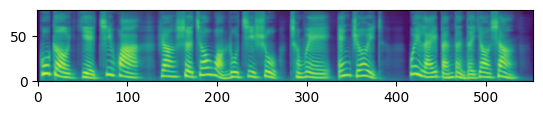

original audio


predicted audio


In [51]:
%matplotlib inline
!pwd
audio, spectrogram = evaluate_spec_fastpitch_ckpt(spec_gen_model, vocoder_model, test)

# visualize the spectrogram
if spectrogram is not None:
    imshow(spectrogram, origin="lower")
    plt.show()

# audio
print("original audio")
ipd.display(ipd.Audio(filename=data_path+test_id+'.wav', rate=22050))
print("predicted audio")
ipd.display(ipd.Audio(audio, rate=22050))

We see that audio quality is not as good as we expect, even after training FastPitch for 1000 epochs. One of the ways mentioned in the [FastPitch_Finetuning.ipynb](FastPitch_Finetuning.ipynb) tutorial is to finetune HiFi-GAN. Lets try that out next!

# Finetuning HiFi-GAN

Improving speech quality by Finetuning HiFi-GAN on synthesized mel-spectrograms from FastPitch. 

## Generating synthetic mels

To generate mel-spectrograms from FastPitch, we can use `generate_spectrogram` method defined in `nemo/collections/tts/models/fastpitch.py`. However, the resulting spectrogram may be different from ground truth mel spectrogram, as shown below:

In [52]:
test_audio_filepath = "NeMoChineseTTS/DataChinese/sf_bilingual_speech_zh_en_vv1/SF_bilingual/wavs/com_SF_ce1.wav"
test_audio_text = "NTHU對面有一條宵夜街。"
# fastpitch_model_path = "<path_to_fastpitch_nemo>"
fastpitch_model_path = "NeMoChineseTTS/resultChineseTTS/FastPitch/2022-10-20_07-13-08/checkpoints/FastPitch.nemo" 

In [53]:
from matplotlib.pyplot import imshow
from nemo.collections.tts.models import FastPitchModel
from matplotlib import pyplot as plt
import librosa
import librosa.display
import torch
import soundfile as sf
import numpy as np
from nemo.collections.tts.torch.helpers import BetaBinomialInterpolator

def load_wav(audio_file):
    with sf.SoundFile(audio_file, 'r') as f:
        samples = f.read(dtype='float32')
    return samples.transpose()

def plot_logspec(spec, axis=None):    
    librosa.display.specshow(
        librosa.amplitude_to_db(spec, ref=np.max),
        y_axis='linear', 
        x_axis="time",
        fmin=0, 
        fmax=8000,
        ax=axis
    )

In [54]:
spec_model = FastPitchModel.restore_from(fastpitch_model_path).eval().cuda()

[NeMo W 2022-10-27 10:22:53 modules:524] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2022-10-27 10:22:53 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: ./train_manifest.json
      sample_rate: 22050
      sup_data_path: ./sup-data-phonemes
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: null
      max_duration: 14
      min_duration: 0.1
      ignore_file: null
  

[NeMo I 2022-10-27 10:22:53 features:225] PADDING: 1
[NeMo I 2022-10-27 10:22:53 save_restore_connector:243] Model FastPitchModel was successfully restored from /mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/resultChineseTTS/FastPitch/2022-10-20_07-13-08/checkpoints/FastPitch.nemo.


So we have 2 types of mel spectrograms that we can use for finetuning HiFi-GAN:

### 1. Original mel spectrogram generated from original audio file

loading original melspec
spectrogram shape =  (80, 407)


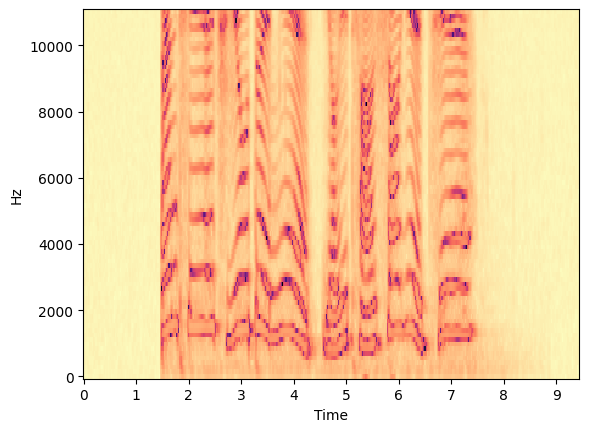

In [55]:
print("loading original melspec")
y, sr = librosa.load(test_audio_filepath)
# change n_fft, win_length, hop_length parameters below based on your specific config file
spectrogram2 = np.log(librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, win_length=1024, hop_length=256))
spectrogram = spectrogram2[ :80, :]
print("spectrogram shape = ", spectrogram.shape)
plot_logspec(spectrogram)
plt.show()

### 2. Mel spectrogram predicted from FastPitch

loading fastpitch melspec via generate_spectrogram
spectrogram shape =  (80, 264)


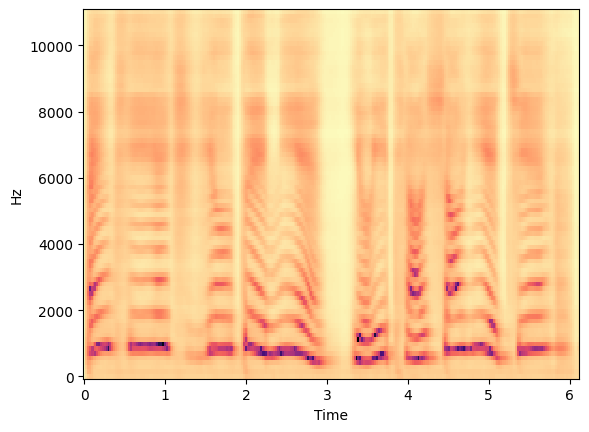

In [56]:
print("loading fastpitch melspec via generate_spectrogram")
with torch.no_grad():
    text = spec_model.parse(test_audio_text, normalize=False)
    spectrogram = spec_model.generate_spectrogram(
      tokens=text, 
      speaker=None,
    )
spectrogram = spectrogram.to('cpu').numpy()[0]
plot_logspec(spectrogram)
print("spectrogram shape = ", spectrogram.shape)
plt.show()

<b>Note</b>: The above spectrogram has the duration 291 which is not equal to the ground truth length, i.e. 315. In order to finetune HiFi-GAN we need mel spectrogram predicted from FastPitch with groundtruth alignment and duration.

### 2.1 Mel spectrogram predicted from FastPitch with groundtruth alignment and duration 

loading fastpitch melspec via forward method with groundtruth alignment and duration
spectrogram shape =  (80, 407)


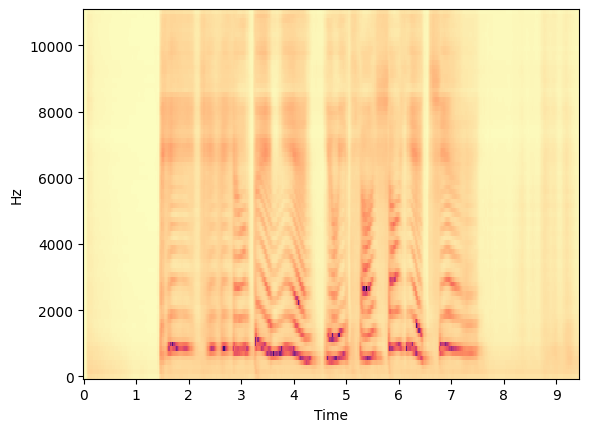

In [57]:
print("loading fastpitch melspec via forward method with groundtruth alignment and duration")
with torch.no_grad():
    device = spec_model.device
    beta_binomial_interpolator = BetaBinomialInterpolator()
    text = spec_model.parse(test_audio_text, normalize=False)
    text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=device).unsqueeze(0)
    audio = load_wav(test_audio_filepath)
    audio = torch.from_numpy(audio).unsqueeze(0).to(device)
    audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)
    spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)
    attn_prior = torch.from_numpy(
      beta_binomial_interpolator(spect_len.item(), text_len.item())
    ).unsqueeze(0).to(text.device)
    spectrogram = spec_model.forward(
      text=text, 
      input_lens=text_len, 
      spec=spect, 
      mel_lens=spect_len, 
      attn_prior=attn_prior,
      speaker=None,
    )[0]
spectrogram = spectrogram.to('cpu').numpy()[0]
print("spectrogram shape = ", spectrogram.shape)
plot_logspec(spectrogram)
plt.show()

In our experience, 
- Finetuning with #1 has artifacts from the original audio (noise) that get passed on as input to the vocoder resulting in artifacts in vocoder output in the form of noise.
- <b> On the other hand, #2.1 (i.e. `Mel spectrogram predicted from FastPitch with groundtruth alignment and duration`) gives the best results because it enables HiFi-GAN to learn mel spectrograms generated by FastPitch as well as duration distributions closer to the real world (i.e. ground truth) durations. </b>

From implementation perspective - we follow the same process described in [Finetuning FastPitch for a new speaker](FastPitch_Finetuning.ipynb) - i.e. take the latest checkpoint from FastPitch training and predict spectrograms for each of the input records in `train_manifest.json`, `test_manifest.json` and `val_manifest.json`.

In [61]:
import json
import numpy as np
import torch
import soundfile as sf
import librosa

from pathlib import Path

from nemo.collections.tts.torch.helpers import BetaBinomialInterpolator

folder_name = "synmels"
#fastpitch_model_path = "<path_to_fastpitch_nemo_or_ckpt>"
fastpitch_model_path = "NeMoChineseTTS/resultChineseTTS/FastPitch/2022-10-20_07-13-08/checkpoints/FastPitch.nemo" 
dataset_parts = ["test_manifest", "val_manifest", "train_manifest"]
dataset_base_path = "NeMoChineseTTS/"

from nemo.collections.tts.models import FastPitchModel
if ".nemo" in fastpitch_model_path:
    spec_model = FastPitchModel.restore_from(fastpitch_model_path).eval().cuda()
else:
    spec_model = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_model_path).eval().cuda()

spec_model.eval().cuda()
    
def load_wav(audio_file):
    with sf.SoundFile(audio_file, 'r') as f:
        samples = f.read(dtype='float32')
    return samples.transpose()
    
for dataset_part in dataset_parts:
    # Get records from the manifest
    manifest_path = f"{dataset_base_path}{dataset_part}.json"
    records = []
    with open(manifest_path, "r") as f:
        for i, line in enumerate(f):
            records.append(json.loads(line))

    beta_binomial_interpolator = BetaBinomialInterpolator()

    spec_model.eval()
    device = spec_model.device

    save_dir = Path(f"{dataset_base_path}{folder_name}/{dataset_part}")

    save_dir.mkdir(exist_ok=True, parents=True)

    # Generate a spectrograms (we need to use ground truth alignment for correct matching between audio and mels)
    for i, r in enumerate(records):
        audio = load_wav(r["audio_filepath"])

        audio = torch.from_numpy(audio).unsqueeze(0).to(device)
        audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)

        # Again, our finetuned FastPitch model doesn't use multiple speakers,
        # but we keep the code to support it here for reference
        if spec_model.fastpitch.speaker_emb is not None and "speaker" in r:
            speaker = torch.tensor([r['speaker']]).to(device)
        else:
            speaker = None

        with torch.no_grad():
            if "normalized_text" in r:
                text = spec_model.parse(r["normalized_text"], normalize=False)
            else:
                text = spec_model.parse(r['text'])

            text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=device).unsqueeze(0)

            spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)

            # Generate attention prior and spectrogram inputs for HiFi-GAN
            attn_prior = torch.from_numpy(
                beta_binomial_interpolator(spect_len.item(), text_len.item())
            ).unsqueeze(0).to(text.device)

            spectrogram = spec_model.forward(
                text=text, 
                input_lens=text_len, 
                spec=spect, 
                mel_lens=spect_len, 
                attn_prior=attn_prior,
                speaker=speaker,
              )[0]

        save_path = save_dir / f"mel_{i}.npy"
        np.save(save_path, spectrogram[0].to('cpu').numpy())
        r["mel_filepath"] = str(save_path)

        hifigan_manifest_path = f"{dataset_base_path}{folder_name}/hifigan_{dataset_part}_ft.json"

        with open(hifigan_manifest_path, "w") as f:
            for r in records:
                f.write(json.dumps(r) + '\n')

[NeMo W 2022-10-27 10:29:12 modules:524] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2022-10-27 10:29:12 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: ./train_manifest.json
      sample_rate: 22050
      sup_data_path: ./sup-data-phonemes
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: null
      max_duration: 14
      min_duration: 0.1
      ignore_file: null
  

[NeMo I 2022-10-27 10:29:12 features:225] PADDING: 1
[NeMo I 2022-10-27 10:29:13 save_restore_connector:243] Model FastPitchModel was successfully restored from /mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/resultChineseTTS/FastPitch/2022-10-20_07-13-08/checkpoints/FastPitch.nemo.


Revisiting how we implement #2.1 (i.e. Predicted mel spectrogram predicted from FastPitch with groundtruth alignment and duration):

1. Notice above that we use audio from dataset (`audio` variable) to compute spectrogram length (`spect_len`):
    ```python
    spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)
    ```
2. and groundtruth alignment (`attn_prior`).
    ```python
    attn_prior = torch.from_numpy(
          beta_binomial_interpolator(spect_len.item(), text_len.item())
        ).unsqueeze(0).to(text.device)
    ```
3. We use both of them to generate synthetic mel spectrogram via `spec_model.forward` method:
    ```python
    spectrogram = spec_model.forward(
          text=text, 
          input_lens=text_len, 
          spec=spect, 
          mel_lens=spect_len, 
          attn_prior=attn_prior,
          speaker=speaker,
        )[0]
    ```
    
Repeat the above script for train and validation datasets as well. 

<!-- Finally, the `NeMoChinese/synmels` will look like:
```
DataGermanTTS/synmels/:
hifigan_test_manifest_phonemes_ft.json
hifigan_train_manifest_phonemes_ft.json
hifigan_val_manifest_phonemes_ft.json
test_manifest_phonemes
train_manifest_phonemes
val_manifest_phonemes

DataGermanTTS/synmels/test_manifest_phonemes:
mel_0.npy
mel_1.npy
...

DataGermanTTS/synmels/train_manifest_phonemes:
mel_0.npy
mel_1.npy
...

DataGermanTTS/synmels/val_manifest_phonemes:
mel_0.npy
mel_1.npy
...
```

Example HiFi-GAN manifest:
```json
{"audio_filepath": "DataGermanTTS/thorsten-de/wavs/e50eb02c25353f85549900d2fc1e0e32.wav", "duration": 2.409977, "text": "Geht die Schandtat auf sein Konto?", "normalized_text": "Geht die Schandtat auf sein Konto?", "mel_filepath": "DataGermanTTS/synmels/test_manifest_phonemes/mel_0.npy"}
``` -->

## Launch finetuning

Download the pre-trained HiFi-GAN from NGC.

In [59]:
!(cd NemoChineseTTS && \
  wget --content-disposition https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_hifigan/versions/1.0.0rc1/zip -O tts_hifigan_1.0.0rc1.zip && \
  unzip tts_hifigan_1.0.0rc1.zip)

--2022-10-27 10:23:37--  https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_hifigan/versions/1.0.0rc1/zip
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 35.162.223.184, 54.69.50.199
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|35.162.223.184|:443... connected.
HTTP request sent, awaiting response... 302 
Location: https://prod-model-registry-ngc-bucket.s3.us-west-2.amazonaws.com/org/nvidia/team/nemo/models/tts_hifigan/versions/1.0.0rc1/files.zip?response-content-disposition=attachment%3B%20filename%3D%22files.zip%22&response-content-type=application%2Fzip&X-Amz-Security-Token=IQoJb3JpZ2luX2VjECoaCXVzLXdlc3QtMiJGMEQCICahLuvTxaqedgCjZMa48CF3yQgXYHjKt8uIvn4E0drrAiA3fv4zxCF1tOTZ4LUuZ%2BWpH0D0uffHlZ1vBRV%2BgL39mSrMBAgTEAQaDDc4OTM2MzEzNTAyNyIMn%2Fw0edU3lu03YEhaKqkEi0bFNuUxVTg9iqfAsn0hddM4qax96ap6lijo0JIB6f4cashIgzrvePmoaNCKrVumPjoNz6x31AR3sH1jxtY4mJLh9%2FKDMxUEjnGaf3jbCZwYrDQmJvA19JMFl5iIOwtMzUki0Dy%2FhfTF1buev9mL%2B0lckyFWF8jeSXl7OPbiEfHiHa0G%2BsyFijzkgAMsQBjOVzabfn8s3ysan4

We will be re-using the existing HiFi-GAN config and HiFi-GAN pretrained on English.

In [62]:
!(python3 NeMoChineseTTS/hifigan_finetune.py --config-path . --config-name hifigan.yaml \
    model.max_steps=10 \
    model.optim.lr=0.00001 \
    ~model.optim.sched \
    train_dataset=NeMoChineseTTS/synmels/hifigan_train_manifest_ft.json \
    validation_datasets=NeMoChineseTTS/synmels/hifigan_val_manifest_ft.json \
    exp_manager.exp_dir=resultChineseTTS \
    +init_from_nemo_model=NeMoChineseTTS/tts_hifigan.nemo \
    trainer.devices=-1 \
    +trainer.val_check_interval=5 \
    trainer.check_val_every_n_epoch=null \
    model/train_ds=train_ds_finetune \
    model/validation_ds=val_ds_finetune \
    exp_manager.create_wandb_logger=true \
    exp_manager.wandb_logger_kwargs.name="tutorial_2" \
    exp_manager.wandb_logger_kwargs.project="ChineseTTS")

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
[NeMo W 2022-10-27 10:32:04 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-10-27 10:32:05 experimental:27] Module <class 'nemo_text_processing.g2p.modules.IPAG2P'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-10-27 10:32:05 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-10-27 10:32:05 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-10-27 10:32:0

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                       | Type                     | Params
------------------------------------------------------------------------
0 | audio_to_melspec_precessor | FilterbankFeatures       | 0     
1 | trg_melspec_fn             | FilterbankFeatures       | 0     
2 | generator                  | Generator                | 13.9 M
3 | mpd                        | MultiPeriodDiscriminator | 41.1 M
4 | msd                        | MultiScaleDiscriminator  | 29.6 M
5 | feature_loss               | FeatureMatchingLoss      | 0     
6 | discriminator_loss         | DiscriminatorLoss        | 0     
7 | generator_loss             | GeneratorLoss            | 0     
------------------------------------------------------------------------
84.7 M    Trainable params
0         Non-trainable params


<b>Note</b>: We've limited the above run to 10 steps only, so we can validate the implementation within the scope of this tutorial. We recommend evaluating around every 50 steps HiFi-GAN until you get desired quality results.

## Evaluating FastPitch and Finetuned HiFi-GAN

Let's evaluate the quality of the FastPitch model generated so far using a HiFi-GAN model finetuned on predicted mels.

In [63]:
#hfg_path = "<path_to_finetuned_hifigan_nemo_or_ckpt>"
hfg_path = "NeMoChineseTTS/tts_hifigan.nemo"
#fastpitch_model_path = "<path_to_fastpitch_nemo_or_ckpt>"
fastpitch_model_path = "NeMoChineseTTS/resultChineseTTS/FastPitch/2022-10-20_07-13-08/checkpoints/FastPitch.nemo" 
if ".nemo" in hfg_path:
    vocoder_model_pt = HifiGanModel.restore_from(hfg_path).eval().cuda()
else:
    vocoder_model_pt = HifiGanModel.load_from_checkpoint(checkpoint_path=hfg_path).eval().cuda()
    
if ".nemo" in fastpitch_model_path:
    spec_gen_model = FastPitchModel.restore_from(fastpitch_model_path).eval().cuda()
else:
    spec_gen_model = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_model_path).eval().cuda()

[NeMo W 2022-10-27 10:34:23 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2022-10-27 10:34:23 modelPT:149] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2022-10-27 10:34:23 features:225] PADDING: 0


[NeMo W 2022-10-27 10:34:23 features:202] Using torch_stft is deprecated and has been removed. The values have been forcibly set to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2022-10-27 10:34:23 features:225] PADDING: 0
[NeMo I 2022-10-27 10:34:25 save_restore_connector:243] Model HifiGanModel was successfully restored from /mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/tts_hifigan.nemo.


[NeMo W 2022-10-27 10:34:27 modules:524] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2022-10-27 10:34:27 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: ./train_manifest.json
      sample_rate: 22050
      sup_data_path: ./sup-data-phonemes
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: null
      max_duration: 14
      min_duration: 0.1
      ignore_file: null
  

[NeMo I 2022-10-27 10:34:27 features:225] PADDING: 1
[NeMo I 2022-10-27 10:34:28 save_restore_connector:243] Model FastPitchModel was successfully restored from /mnt/samsung-t7/yuekai/tts/NeMoChineseTTS/resultChineseTTS/FastPitch/2022-10-20_07-13-08/checkpoints/FastPitch.nemo.


torch.Size([1, 80, 553])


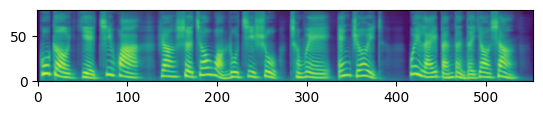

original audio


predicted audio


In [64]:
%matplotlib inline

audio, spectrogram = evaluate_spec_fastpitch_ckpt(spec_gen_model, vocoder_model_pt, test)

# visualize the spectrogram
if spectrogram is not None:
    imshow(spectrogram, origin="lower")
    plt.show()

# audio
print("original audio")
ipd.display(ipd.Audio(data_path+test_id+'.wav', rate=22050))
print("predicted audio")
ipd.display(ipd.Audio(audio, rate=22050))

That's it!